In [1]:
from dotenv import load_dotenv
load_dotenv()

True

# Replicate x Whisper

## Wishlist
- [ ] When querying these chunks consecutive chunks need to be grouped because the chunks are too small
			
	Idea 1:
	- Store these small chunks as is
	- Chunk the whole transcript, embed and store like a normal txt file
	- Extract chunks from the embedded ones and then get the start and end timestamps by comparing the text with the stored small chunks

In [2]:
import replicate
import json

In [3]:
# output = replicate.run(
#     "openai/whisper:91ee9c0c3df30478510ff8c8a3a545add1ad0259ad3a9f78fba57fbc05ee64f7",
#     input={"audio": open("./data/youtube/Sal Khan's thoughts on mastery learning.m4a", "rb")}
# )
# print(output)
# with open("./data/youtube/Sal Khan's thoughts on mastery learning - Replicate x Whisper API Response.json", 'w') as f:
# 	json.dump(output, f)

In [4]:
# with open("./data/youtube/Sal Khan's thoughts on mastery learning - Transcription.txt", "w") as f:
# 	f.write(output['transcription'])

# with open("./data/youtube/Sal Khan's thoughts on mastery learning - Segments.txt", "a") as f:
# 	for chunk in output['segments']:
# 		f.write(chunk['text'] + "\n")

In [5]:
output = json.load(open("./data/youtube/Sal Khan's thoughts on mastery learning - Replicate x Whisper API Response.json", 'r'))

In [6]:
list(output.keys())

['detected_language', 'segments', 'transcription', 'translation']

In [7]:
output['segments'][0]

{'avg_logprob': -0.3576602739157136,
 'compression_ratio': 1.6016260162601625,
 'end': 7,
 'id': 0,
 'no_speech_prob': 0.00015473616076633334,
 'seek': 0,
 'start': 0,
 'temperature': 0,
 'text': ' This idea of mastery learning was always kind of this gold standard.',
 'tokens': [50364,
  639,
  1558,
  295,
  37951,
  2539,
  390,
  1009,
  733,
  295,
  341,
  3821,
  3832,
  13,
  50714]}

In [8]:
transcript = "\n".join([segment['text'] for segment in output['segments']])
transcript = transcript.strip()

In [9]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.docstore.document import Document

In [10]:
textSplitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)

In [11]:
transcriptChunks = textSplitter.create_documents([ transcript ])
transcriptChunks

[Document(page_content="This idea of mastery learning was always kind of this gold standard.\n This was actually as a part of a fellowship I had while I was at MIT called the El Orante Fellowship\n to make a learning software for students with ADHD.\n It is X plus 5 times X plus...\n And it immediately struck a chord with me because going into that,\n the whole premise of the software that I was working on was this idea that\n it's not that students aren't capable of learning some advanced mathematics", metadata={}),
 Document(page_content="it's not that students aren't capable of learning some advanced mathematics\n or that the topics are actually difficult,\n it's more that they just have gaps in their knowledge.\n And I did a lot of tutoring in high school and I saw that over and over again\n that the reason why students were having...\n My friends were having trouble with algebra or geometry.\n It was just because they had a gap in their negative numbers\n or dividing decimals or l

Add consecutive segments of the video as `metadata` to each chunk of the transcript

In [12]:
SEGMENT_OVERLAP_SECONDS = 2
chunksWithSegments = []

for chunk in transcriptChunks:
    chunkText = chunk.page_content

    chunkSegments = []
    for segment in output['segments']:
        if segment['text'].strip() in chunkText:
            chunkSegments.append(segment)

    # Store consecutive segments as one segment
    consecutiveSegments = [{
        'start': chunkSegments[0]['start'],
        'end': chunkSegments[0]['end']
    }]

    for segment in chunkSegments[1:]:
        lastSegmentEnd = consecutiveSegments[-1]['end']
        if segment['start'] in range(lastSegmentEnd, lastSegmentEnd + SEGMENT_OVERLAP_SECONDS):
            consecutiveSegments[-1]['end'] = segment['end']
        else:
            consecutiveSegments.append({
                'start': segment['start'],
                'end': segment['end']
            })
    
    chunksWithSegments.append(Document(
        page_content=chunkText,
        metadata={
        'title': "Sal Khan's thoughts on mastery learning",
        'segments': json.dumps(consecutiveSegments)
        })
    )


When you see multiple segments its probably music or parts when nobody spoke

In [13]:
print("Text")
print(chunksWithSegments[2].page_content)
print()
print("Segments")
print(chunksWithSegments[2].metadata['segments'])

Text
or dividing decimals or logarithms or whatever else.
 First time in a spile...
 Good students start failing algebra all of a sudden
 and start failing calculus all of a sudden,
 despite it being smart, despite having good teachers,
 and it's usually because they had these Swiss cheese gaps
 that kept building throughout their foundations.
 Now, a lot of skeptics might say,
 well, hey, this is all great philosophically,
 this whole idea of mastery-based learning and its connection to mindset,

Segments
[{"start": 49, "end": 53}, {"start": 58, "end": 80}]


In [15]:
# db = Chroma.from_documents(documents=chunksWithSegments, embedding=OpenAIEmbeddings(), persist_directory="./youtube_chunks_db")
# db.persist()
# db = None

In [16]:
db = Chroma(persist_directory="./youtube_chunks_db/", embedding_function=OpenAIEmbeddings())

In [18]:
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI


qa = RetrievalQA.from_chain_type(
    llm=ChatOpenAI(model="gpt-3.5-turbo-0613"),
    chain_type="stuff",
    retriever=db.as_retriever(),
    return_source_documents=True
)

In [21]:
res = qa("What did the skeptics say?")
print(res['result'])

The skeptics said that it's not that students aren't capable of learning advanced mathematics or that the topics are actually difficult. Instead, they believe that students struggle because they have gaps in their knowledge or foundations.


In [41]:
res

{'query': 'What did the skeptics say?',
 'result': "The skeptics said that it's not that students aren't capable of learning advanced mathematics or that the topics are actually difficult. Instead, they believe that students struggle because they have gaps in their knowledge or foundations.",
 'source_documents': [Document(page_content="or dividing decimals or logarithms or whatever else.\n First time in a spile...\n Good students start failing algebra all of a sudden\n and start failing calculus all of a sudden,\n despite it being smart, despite having good teachers,\n and it's usually because they had these Swiss cheese gaps\n that kept building throughout their foundations.\n Now, a lot of skeptics might say,\n well, hey, this is all great philosophically,\n this whole idea of mastery-based learning and its connection to mindset,", metadata={'title': "Sal Khan's thoughts on mastery learning", 'segments': '[{"start": 49, "end": 53}, {"start": 58, "end": 80}]'}),
  Document(page_conte

In [47]:
from IPython import display

Start: 49, End: 53


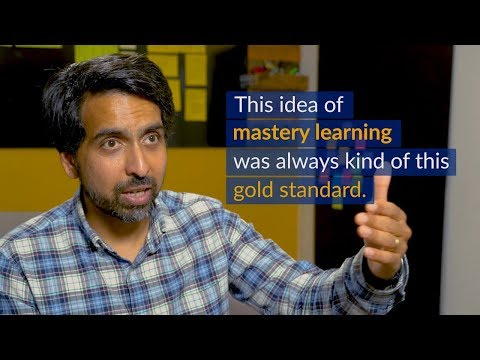

Start: 58, End: 80


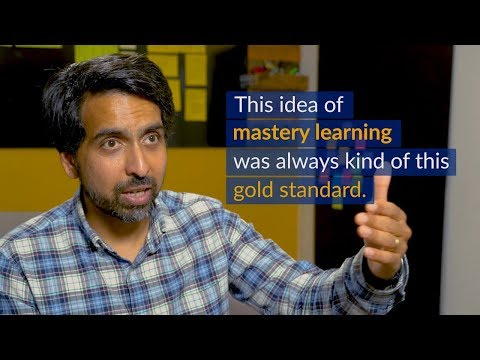

In [49]:
rawSegments = res['source_documents'][0].metadata['segments']
segments = json.loads(rawSegments)
for segment in segments:
	start = segment['start']
	end = segment['end']
	print(f"Start: {start}, End: {end}")
	display.display(display.YouTubeVideo("lGaQWIV8PZ4", width=400, height=200, start=start, end=end))